In [25]:
import tools
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from scipy import integrate
import torch.nn.functional as F
from scipy.interpolate import interp1d
from tensorboardX import SummaryWriter

In [26]:
x_dict = tools.get_all_surfacelines('rijnland')

In [27]:
y_dict = tools.get_all_cpoints('rijnland')

In [28]:
x = [np.array(list(map(lambda x: [x[1], x[2]], p))) for p in [x_dict[k] for k in x_dict.keys()]]

# clicked points
y = [np.array(list(map(lambda x: [x[0], x[1], x[2]], p))) for p in [y_dict[k] for k in x_dict.keys()]]

In [29]:
labels = []
for i in range(len(x)):
#     mask = np.isin(y[i][:, 0], np.array([5, 8, 9, 10, 11, 14]))
    mask = np.isin(y[i][:, 0], np.array([5]))
    idx = [np.argmin(np.sum(np.abs(x[i] - p), 1), axis=0) for p in y[i][mask][:, 1:]]
    l = np.zeros(x[i].shape[0], dtype=bool)
    l[idx] = True
    labels.append(l)
y = labels
del labels

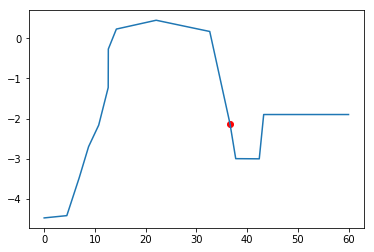

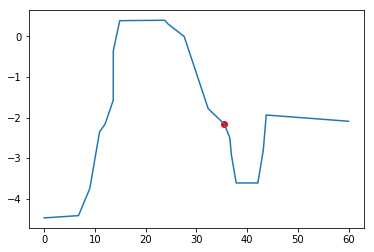

In [30]:
def plot_dyke(x, y, a):
    mask = np.array(y[a], dtype=bool)
    
    plt.plot(x[a][:, 0], x[a][:, 1])
    plt.scatter(x[a][:, 0][mask], x[a][:, 1][mask], c='r')
    
#     idx = np.argmax(x[a][:, 1])
#     plt.scatter(x[a][idx, 0], x[a][idx, 1], c='purple')
    plt.show()

for i in range(2):
    plot_dyke(x, y, i)

In [31]:
def scale_features(x):
    return (x - x.min(0)) / (x.max(0) - x.min(0))

x = list(map(scale_features, x))

In [32]:
# Turn data in [label, x_coordinate, y_coordinate]
data = list(map(lambda t: np.hstack((t[1][:, None], t[0])), zip(x, y)))

In [33]:
data[0]

array([[0.        , 0.        , 0.        ],
       [0.        , 0.0744    , 0.01156891],
       [0.        , 0.1148    , 0.20154252],
       [0.        , 0.14596667, 0.36066572],
       [0.        , 0.1792    , 0.46945403],
       [0.        , 0.2104    , 0.65942764],
       [0.        , 0.2108    , 0.85427238],
       [0.        , 0.2372    , 0.95534808],
       [0.        , 0.368     , 1.        ],
       [0.        , 0.50233333, 0.95656586],
       [0.        , 0.544     , 0.94317029],
       [1.        , 0.61066667, 0.47554293],
       [0.        , 0.62935   , 0.29977674],
       [0.        , 0.70671667, 0.29896489],
       [0.        , 0.72126667, 0.52303633],
       [0.        , 1.        , 0.52303633]])

In [34]:
len(data)

1440

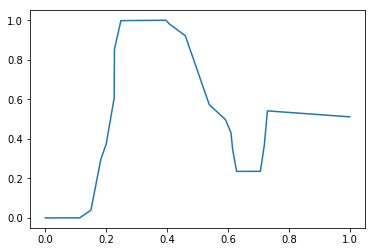

In [35]:
a = 2
f = interp1d(data[a][:, 1], data[a][:, 2])
x = np.linspace(0, 1, 1000)

plt.plot(x, f(x))

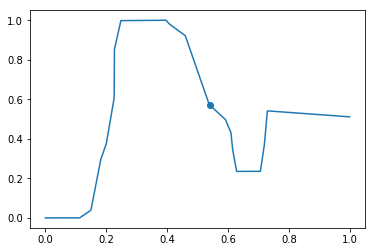

In [36]:
def distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

# get broadcasted distance between all the points.
# if called with x, y from a long array with shape (100, 1)
# and compared with a smaller array with shape (10, )
# the output will be broadcasted to (100, 10)

# get all points that are labels
# return [x, y]
a = 2
p = data[a][:, 1:][data[a][:, 0] == 1]

r = distance(x[:, None], f(x)[:, None], p[:, 0], p[:, 1])

idx = r.argmin(0)
plt.plot(x, f(x))
plt.scatter(x[idx], f(x)[idx])

In [37]:
# def rotation_matrix(angle):
#     a = np.radians(angle)
#     return np.array([
#         [np.cos(a), -np.sin(a)],
#         [np.sin(a), np.cos(a)]
#     ])

# data[0][:, 1:] @ rotation_matrix(1)

# new_data = []
# for i in range(1000):
#     angle = np.random.rand() * 5
#     a = data[i][:, 1:] @ rotation_matrix(angle)
#     a = scale_features(a)
#     a = np.concatenate((data[i][:, 0][:, None], a), axis=1)
#     new_data.append(a)
# data = new_data + data

In [38]:
x = np.linspace(0, 1, 50)
y = list(map(lambda a: interp1d(a[:, 1], a[:, 2])(x), data))

In [39]:
x = np.stack(y)

# add diff
x = np.hstack((x, np.diff(x)))

In [40]:
labels = list(map(lambda x: x[:, 1:][np.isclose(x[:, 0], 1, atol=1e-6)], data))

In [41]:
y = np.stack(labels)[:, -1]

In [42]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.LeakyReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(hidden_size, hidden_size),
#             nn.BatchNorm1d(hidden_size),
#             nn.LeakyReLU(),
#             nn.Dropout(0.3),
            nn.Linear(hidden_size, output_size)
        )
        
    def forward(self, x):
        return self.model(x)
    
m = MLP(x.shape[1], 70, 2)
m(torch.tensor(x).cpu().float())

tensor([[ 0.3953, -0.2295],
        [ 0.2737, -0.3271],
        [ 0.2665, -0.3688],
        ...,
        [ 0.1821, -0.1592],
        [ 0.2586, -0.1959],
        [ 0.2586, -0.1959]], grad_fn=<ThAddmmBackward>)

In [43]:
x = torch.tensor(x).float().cuda()
y = torch.tensor(y).float().cuda()

In [54]:
# idx = np.arange(x.shape[0])
# np.random.shuffle(idx)
# x = x[idx]
# y = y[idx]

In [55]:
a = 1000
x_train = x[:a]
y_train = y[:a]
y_dev = y[a:]
x_dev = x[a:]

In [46]:
m = MLP(x.shape[1], 130, 2)
m.cuda()

MLP(
  (model): Sequential(
    (0): Linear(in_features=99, out_features=130, bias=True)
    (1): BatchNorm1d(130, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=130, out_features=130, bias=True)
    (4): BatchNorm1d(130, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=130, out_features=2, bias=True)
  )
)

In [47]:
tb = SummaryWriter('tb/mlp-2-layer-130hn_data_shuffled-berore-50y-points-difference')

In [48]:
criterion = nn.MSELoss()
optim = torch.optim.Adam(m.parameters(), lr=0.001)

epochs = 10_000
batch_size = 50
print_iter = 100
tboard = True
m.train(True)

def test_eval():
    batch_pred, batch_y = get_prediction(x_test, y_test)
    batch_pred = batch_pred.cpu().data.numpy().argmax(1)
    batch_y = batch_y.cpu().data.numpy()
    return batch_pred, batch_y

idx = np.arange(len(x_train))    

for epoch in range(epochs):

    np.random.shuffle(idx)
    x_train = x_train[idx]
    y_train = y_train[idx]
        
    current_batch = 0
    for iteration in range(y_train.shape[0] // batch_size):
        batch_x = x_train[current_batch: current_batch + batch_size]
        batch_y = y_train[current_batch: current_batch + batch_size]
        current_batch += batch_size
                        
        
        if len(batch_x) > 0:
            batch_pred = m(batch_x)
            optim.zero_grad()
            
            loss = criterion(batch_pred, batch_y)

            loss.backward()
            optim.step()
        
    
    if iteration % print_iter == 0:
        print(loss)
            
    if tboard:
        tb.add_scalar('loss', loss.item())
        
        with torch.no_grad():
            m.train(False)
            batch_pred = m(x_dev)
            dev_loss = criterion(batch_pred, y_dev)
            tb.add_scalar('dev-loss', dev_loss)
            m.train(True)

        print(f'loss: {loss.item()}, dev-loss: {dev_loss}')

            
            
                    
        

loss: 0.08461108803749084, dev-loss: 0.1919909417629242
loss: 0.030977580696344376, dev-loss: 0.0461847223341465
loss: 0.020387453958392143, dev-loss: 0.025492362678050995
loss: 0.02470417506992817, dev-loss: 0.02789289690554142
loss: 0.0128642488270998, dev-loss: 0.02402232401072979
loss: 0.011261004954576492, dev-loss: 0.025005461648106575
loss: 0.0172128826379776, dev-loss: 0.026648253202438354
loss: 0.00912416260689497, dev-loss: 0.025220686569809914
loss: 0.017180809751152992, dev-loss: 0.024642808362841606
loss: 0.016137177124619484, dev-loss: 0.02474464662373066
loss: 0.010004975832998753, dev-loss: 0.02360508404672146
loss: 0.012084858492016792, dev-loss: 0.025247834622859955
loss: 0.010432425886392593, dev-loss: 0.023791596293449402
loss: 0.013419544324278831, dev-loss: 0.02376817725598812
loss: 0.014616258442401886, dev-loss: 0.026538116857409477
loss: 0.00988288689404726, dev-loss: 0.024585777893662453
loss: 0.007950314320623875, dev-loss: 0.024284016340970993
loss: 0.010104

KeyboardInterrupt: 

In [265]:

batch_pred = m(x_dev[:20])

In [266]:
batch_pred

tensor([[0.8160, 0.6699],
        [0.6631, 0.5295],
        [0.6066, 0.0812],
        [0.5537, 0.1982],
        [0.6716, 0.3970],
        [0.6264, 0.6132],
        [0.7312, 0.2828],
        [0.6496, 0.5568],
        [0.5813, 0.4652],
        [0.6625, 0.0734],
        [0.6625, 0.0734],
        [0.6625, 0.0734],
        [0.4771, 0.6345],
        [0.4785, 0.5533],
        [0.5113, 0.5607],
        [0.4518, 0.4064],
        [0.5319, 0.4596],
        [0.5319, 0.4596],
        [0.4518, 0.4064],
        [0.4796, 0.6735]], device='cuda:0', grad_fn=<ThAddmmBackward>)

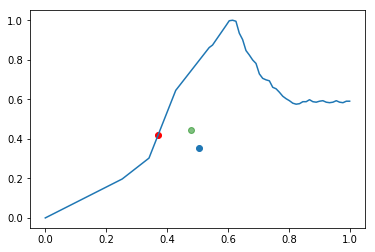

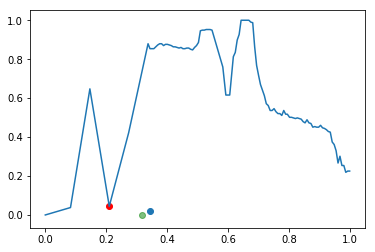

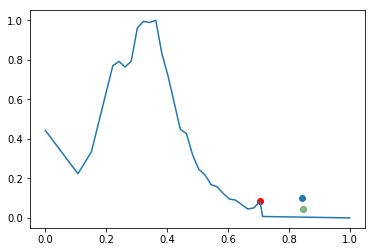

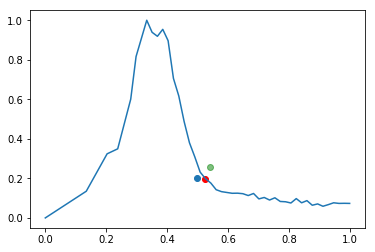

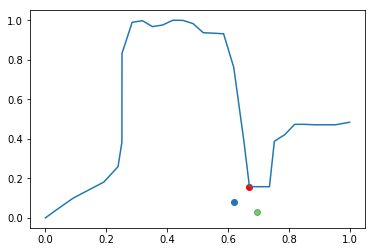

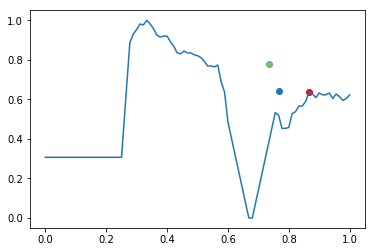

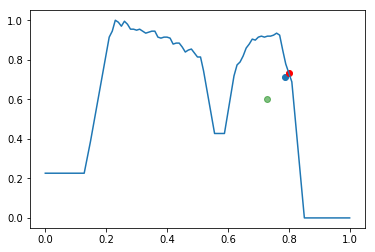

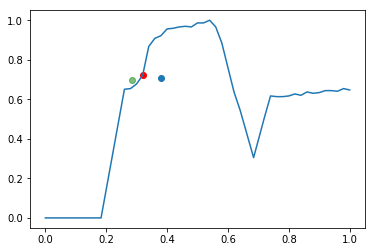

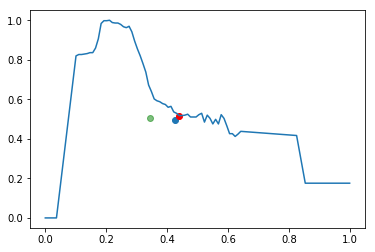

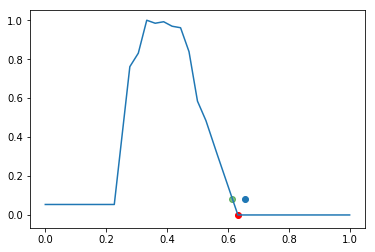

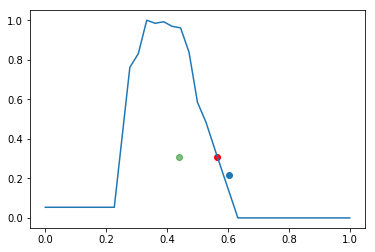

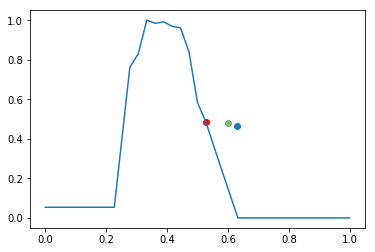

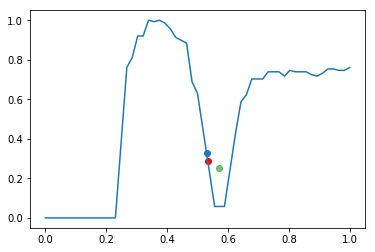

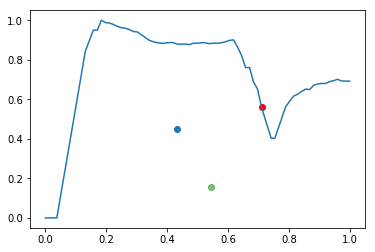

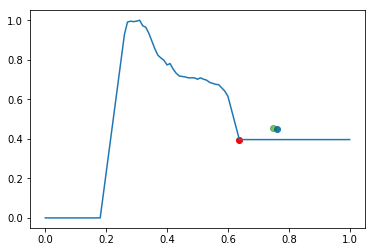

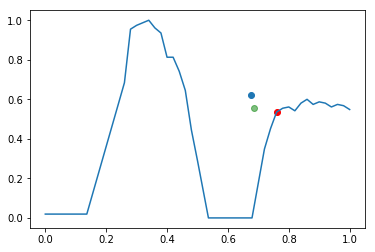

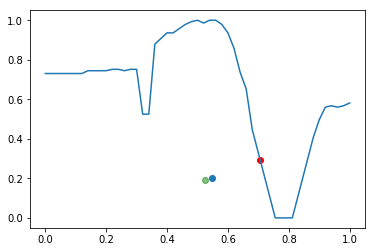

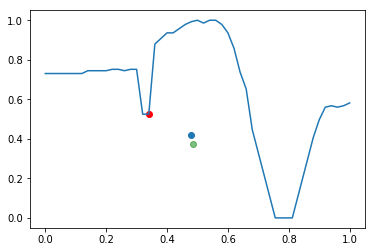

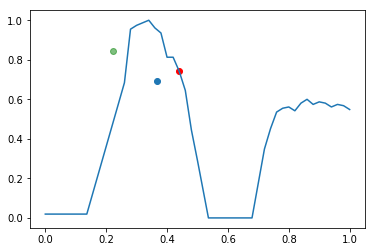

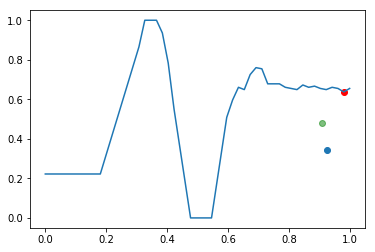

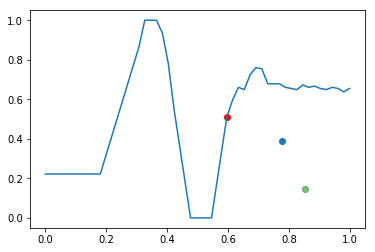

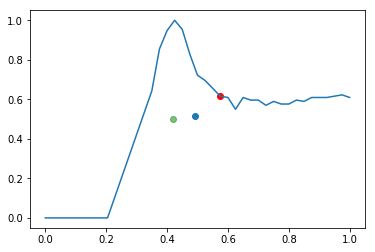

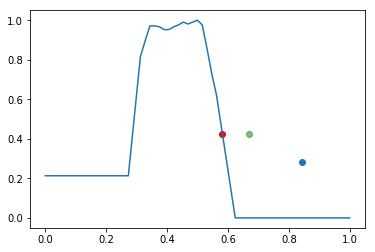

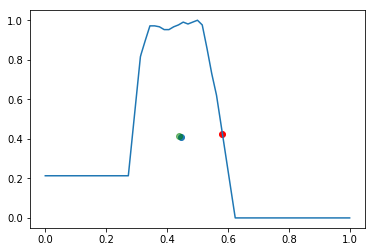

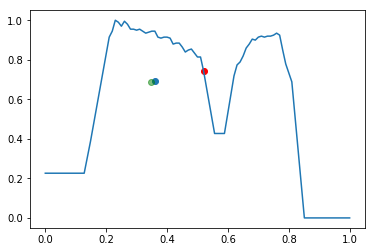

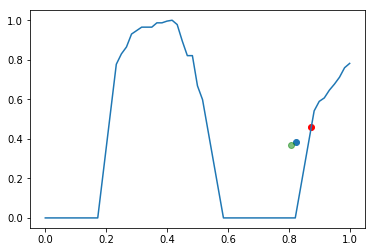

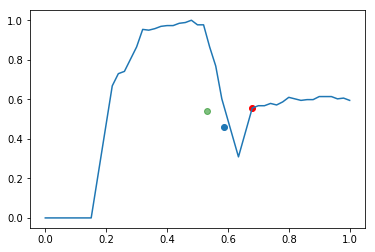

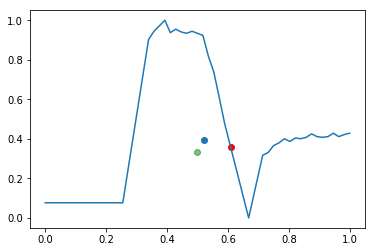

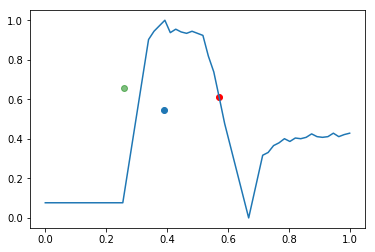

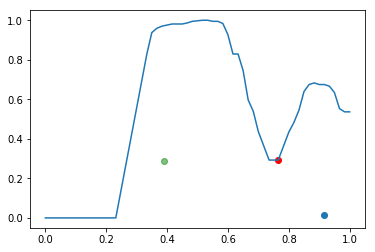

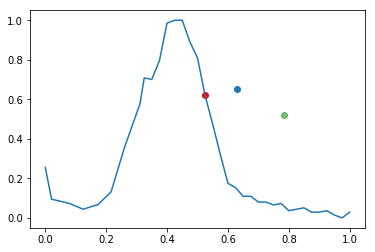

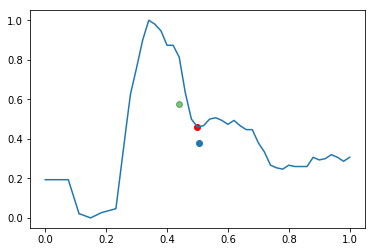

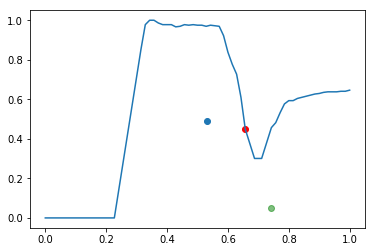

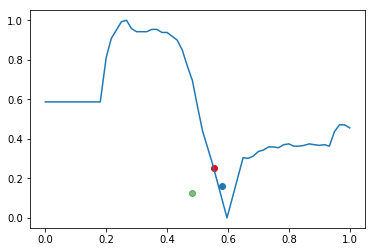

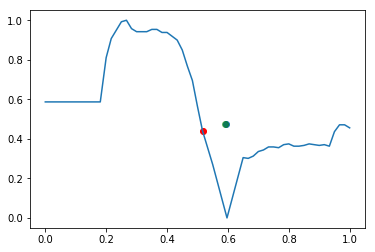

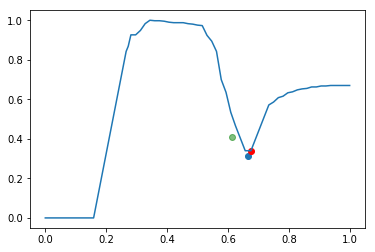

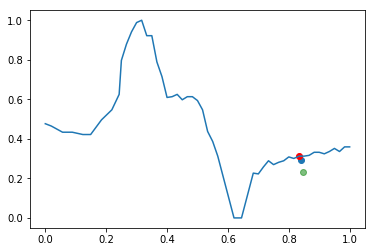

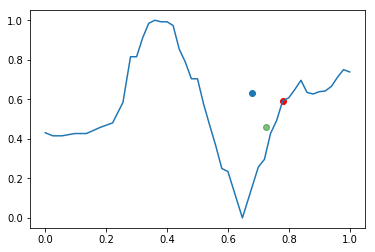

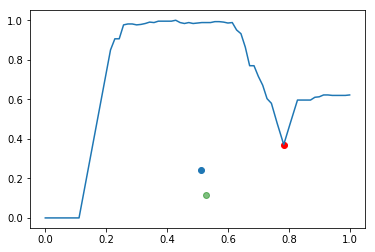

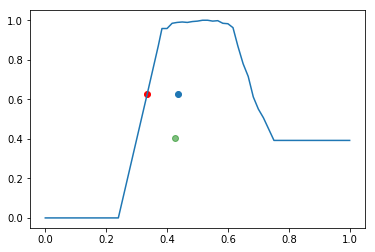

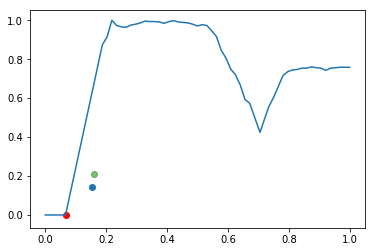

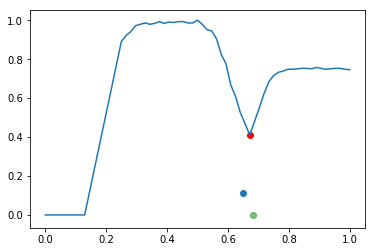

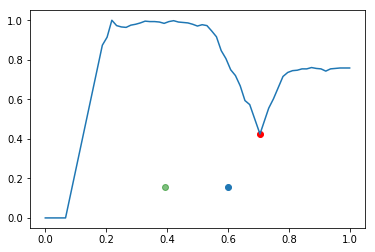

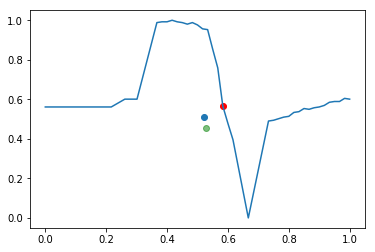

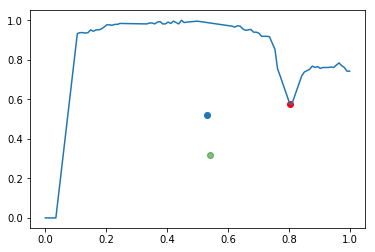

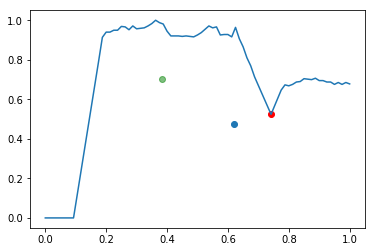

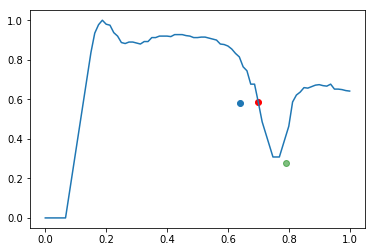

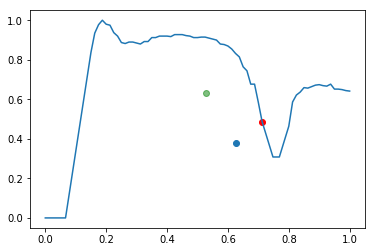

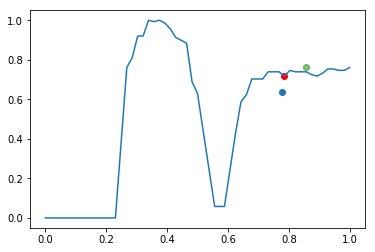

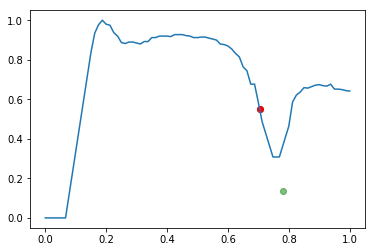

In [52]:
a = 1000
b = 50
m.train(False)
batch_pred = m(x_dev[:b])
for i in range(b):
    X = data[a + i][:, 1]
    Y = data[a + i][:, 2]
    plt.plot(X, Y)
    
    x_ = batch_pred[i, 0].cpu().data.numpy()
    y_ = batch_pred[i, 1].cpu().data.numpy()
    
    idx = distance(X, Y, x_, y_).argmin()
    
    plt.scatter(x_, y_)
    plt.scatter(X[idx], Y[idx], color='r')
    plt.scatter(y_dev[i][0], y_dev[i][1], color='green', alpha=0.5)
    plt.show()